# 2 전투 활동으로 이탈 예측

* 1. 전처리한 데이터 불러오기

In [1]:
import pandas as pd
df = pd.read_csv("c:/vscode/미니프로젝트/2_분류_프로젝트/data/combat_sum.csv")
df.head(2)

,acc_id,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,survive
0,2,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1
1,5,173,0.0,0.0,0.0,0.479728,0.0,0.0,0.098129,0


* 2. 변수 선택

In [2]:
train_cols=df.columns[1:9] #0~18
X=df[train_cols] #독립변수
y=df['survive'] #종속변수

In [3]:
train_cols

Index(['level', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'temp_cnt', 'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
      dtype='object')

In [25]:
import statsmodels.api as sm
model= sm.OLS(y,X)
result=model.fit()
print(result.summary())
#모델의 설명력 40%
#citations 변수는 유의하지 않음 : random_attacker_cnt, num_opponent

                                 OLS Regression Results                                
Dep. Variable:                survive   R-squared (uncentered):                   0.407
Model:                            OLS   Adj. R-squared (uncentered):              0.407
Method:                 Least Squares   F-statistic:                              3535.
Date:                Fri, 21 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:37:24   Log-Likelihood:                         -29196.
No. Observations:               36008   AIC:                                  5.841e+04
Df Residuals:                   36001   BIC:                                  5.846e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [4]:
#로지스틱 회귀분석
import statsmodels.api as sm

model=sm.Logit(y,X) #로지스틱 회귀분석 모형
result=model.fit()
print(result.summary2()) # 요약정보
#모형의 설명력 : 2.8%
#유의하지 않은 변수들 : 'game_money_change'

Optimization terminated successfully.
         Current function value: 0.669041
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.028     
Dependent Variable:  survive           AIC:               53539.2704
Date:                2023-04-21 14:32  BIC:               53608.0435
No. Observations:    40000             Log-Likelihood:    -26762.   
Df Model:            7                 LL-Null:           -27526.   
Df Residuals:        39992             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
level                0.0005   0.0000  23.3378 0.0000  0.0005  0.0006
pledge_cnt           0.0218 

In [5]:
#후진제거법
#최종적으로 선택한 독립변수
train_cols = ['level', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
            'same_pledge_cnt', 'etc_cnt', 'num_opponent']

df['survive'].value_counts() #샘플링 전의 0,1 분포

1    21996
0    18004
Name: survive, dtype: int64

* 3. 언더샘플링

In [6]:
from imblearn.under_sampling import RandomUnderSampler

X_sample,y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)
X_samp=pd.DataFrame(data=X_sample,columns=train_cols)
y_samp=pd.DataFrame(data=y_sample,columns=['survive'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
df_samp['survive'].value_counts() #샘플링 후의 0,1 분포

0    18004
1    18004
Name: survive, dtype: int64

In [7]:
#샘플링 데이터셋에서 X,y 선택
X = X_samp[train_cols]
y = y_samp['survive']

* 4. 알고리즘별 비교

In [8]:
#다양한 알고리즘별 정확도를 저장할 리스트
scores = []

In [9]:
# 1) 로지스틱 회귀분석
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=0)),
])
params = {
    'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__C': 0.01}
0.5972006692822157


In [10]:
# 2) 의사결정나무
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=0)),
])
params = {
    'clf__max_depth': list(range(3,6))
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__max_depth': 5}
0.6438014818167739


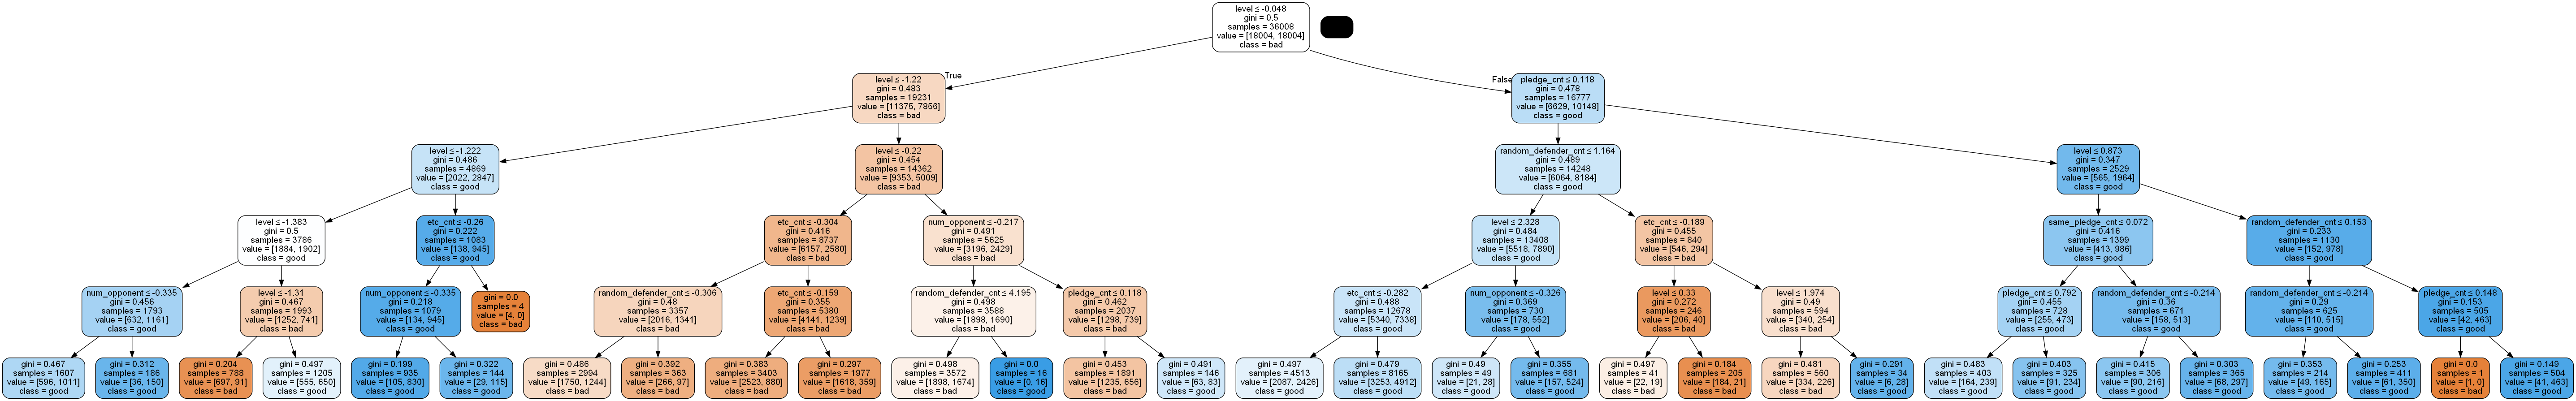

In [11]:
# 2-2) 특성중요도
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image

tree=grid.best_estimator_['clf']
dot_data = export_graphviz(tree, out_file=None,
        feature_names=train_cols, class_names=["bad","good"],
filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

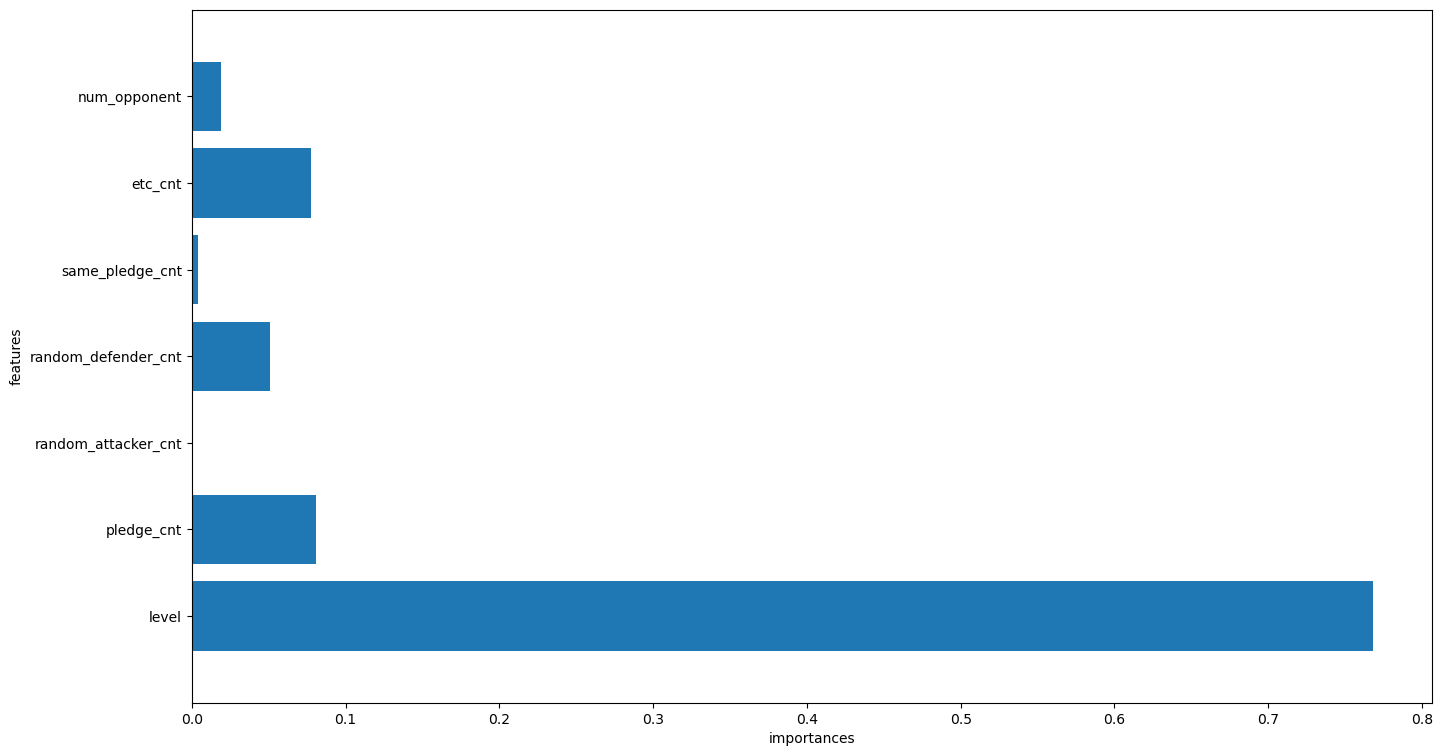

In [12]:
# 2-2) 특성중요도
import numpy as np
import matplotlib.pyplot as plt

def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams["figure.figsize"]=(16,9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("importances")
    plt.ylabel("features")
    plt.ylim(-1, n_features)
plot_tree(tree)

In [ ]:
# 중요도 높은 변수 : level

In [13]:
# 3) 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0)),
])
params = {
    'clf__max_depth': list(range(3,6)),
    'clf__n_estimators': list(range(10,110,10)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__max_depth': 5, 'clf__n_estimators': 80}
0.6336925137524522


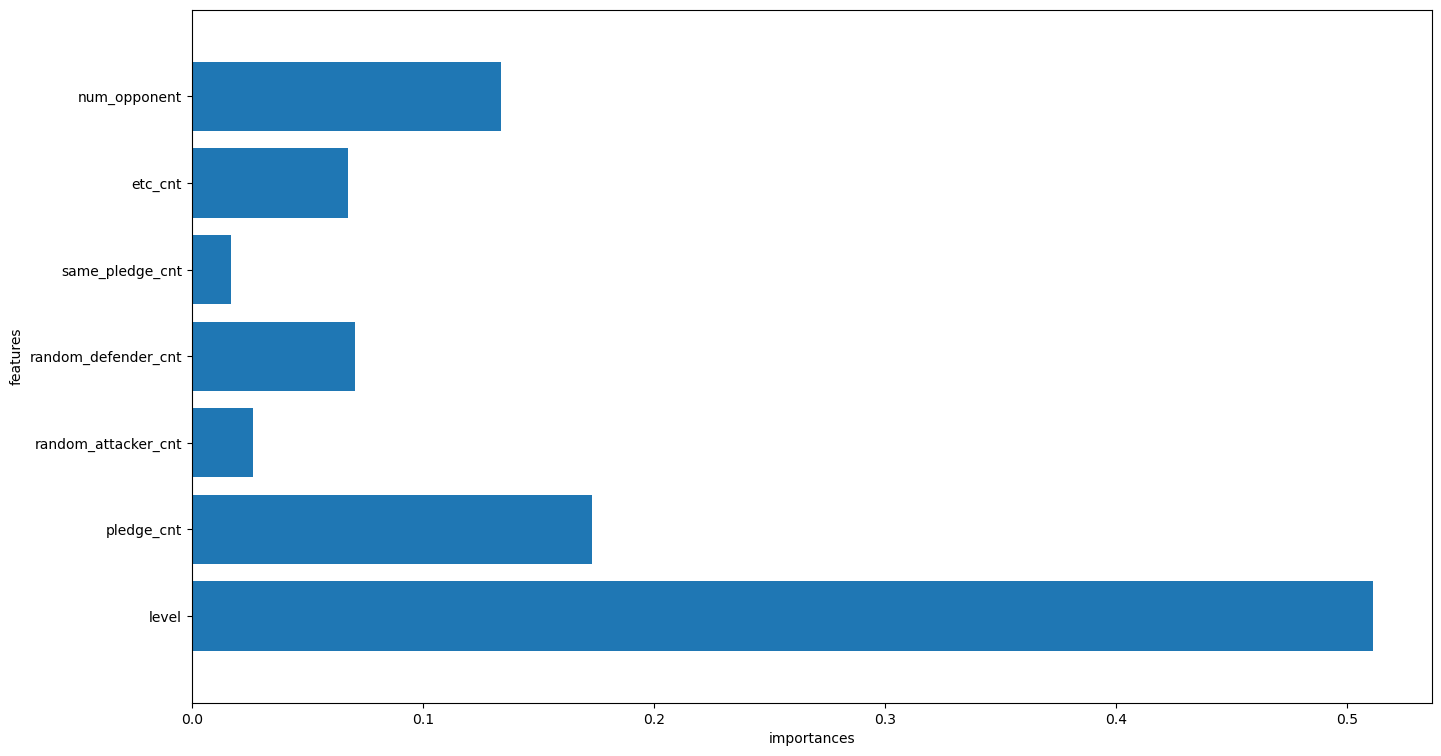

In [14]:
# 3-2) 특성중요도
rf=grid.best_estimator_['clf']
plot_tree(rf)
# # 중요도 높은 변수 : level

In [15]:
# 4) knn
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier()),
])
params = {
    'clf__n_neighbors': list(range(1,6)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

{'clf__n_neighbors': 5}
0.5790658303873734


In [16]:
# 5) 인공신경망
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(random_state=0, max_iter=5000)),
])
params = {
    'clf__hidden_layer_sizes': [(50,), (100,)],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__hidden_layer_sizes': (100,)}
0.6283048213487742


In [17]:
# 6) svm
from sklearn.svm import SVC

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=0)),
])
params = {
    'clf__C': [0.01, 0.1],
    'clf__gamma': [0.001, 0.01],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

{'clf__C': 0.1, 'clf__gamma': 0.01}
0.5776493002968962


In [ ]:
# 7) keras
from scikeras.wrappers import KerasClassifier
from keras import models
from keras import layers

def create_network(optimizer="rmsprop"):
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation="relu",
    input_shape=(X.shape[1],)))
    # network.add(layers.Dense(units=16, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss='binary_crossentropy',
                    optimizer=optimizer, # 옵티마이저
                    metrics=["accuracy"]) # 성능 지표
    return network

neural_network = KerasClassifier(model=create_network, verbose=0)
# 하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('scaler',StandardScaler()),
    ('clf',neural_network)
])
params={
    'clf__epochs': [50, 100],
    'clf__batch_size': [32,64],
    'clf__optimizer': ["rmsprop", "adam"],
}
grid=GridSearchCV(pipe,params,scoring='accuracy',cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

scores.append(grid.best_score_)

* 5. 알고리즘별 예측도 그래프

['LOGIT', 'Tree', 'RF', 'KNN', 'ANN', 'SVM', 'DNN']
[0.69851147 0.69276262 0.71395252 0.70423237 0.71475783 0.70473232
 0.71461897]
최적의 알고리즘: ANN
최적의 정확도: 0.71475782806784


Text(0, 0.5, 'Accuracy')

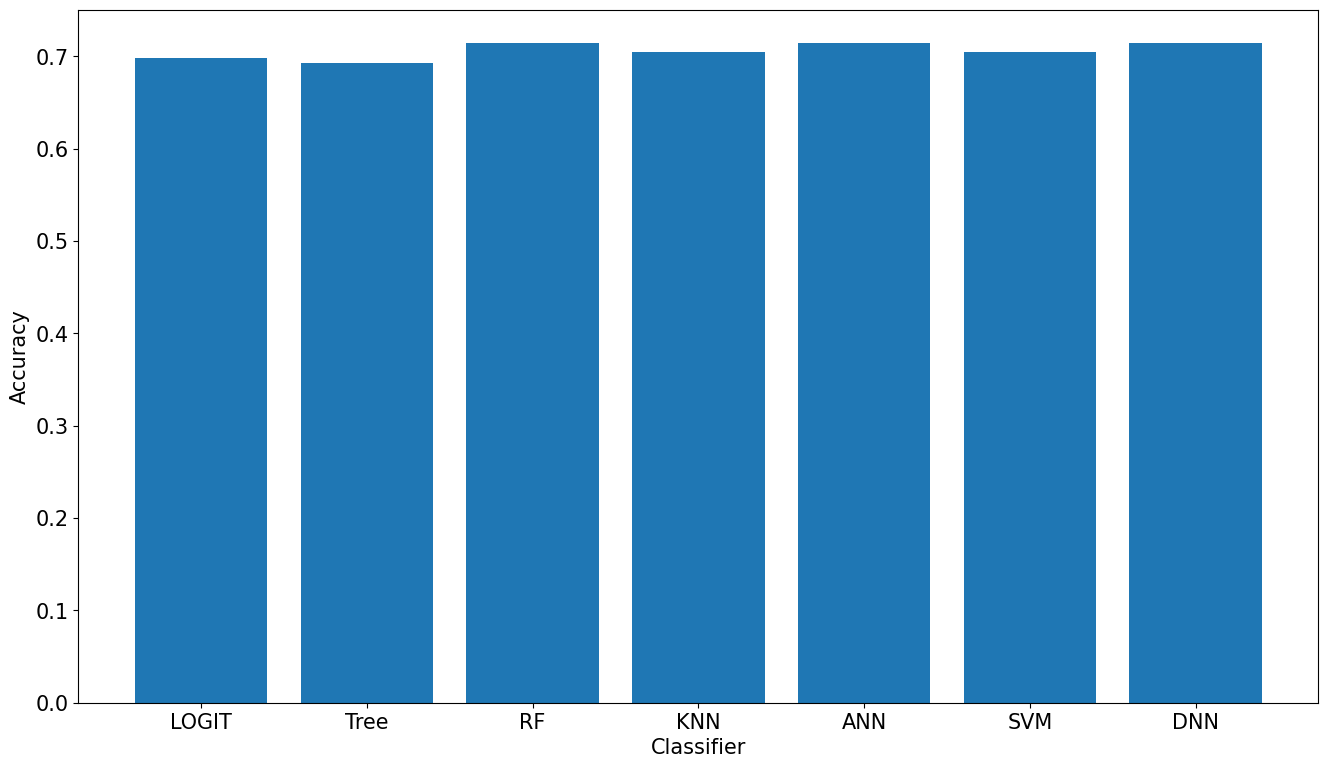

In [25]:
methods=["LOGIT","Tree","RF","KNN","ANN","SVM","DNN"]

scores_arr=np.array(scores) #검증용 데이터셋의 정확도
max_rate=np.max(scores_arr) #가장 좋은 정확도
idx=np.argmax(scores_arr) #최대값의 인덱스

print(methods)
print(scores_arr)
print("최적의 알고리즘:",methods[idx])
print("최적의 정확도:",max_rate)

plt.rcParams["font.size"]=15
plt.bar(methods, scores_arr)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")